In [1]:
import time

import numpy as np
from numpy import genfromtxt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from numba import jit

In [3]:
import scipy.special as ss
import scipy.signal as sig
import scipy.interpolate as interp

In [4]:
# general work flow
# read in CSV file
mcsol = genfromtxt('mcsolgauss.csv',delimiter=',')
print(mcsol.shape)

(401,)


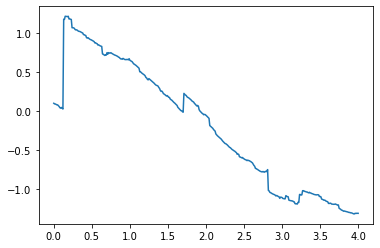

In [5]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

# time vector
tvec = np.arange(mcsol.shape[0])*h

plt.plot(tvec, mcsol)
plt.show()

<ipython-input-6-10a9d687dc80>:21: RuntimeWarning: divide by zero encountered in log
  plt.plot(uvec, np.log(xi(uvec)))


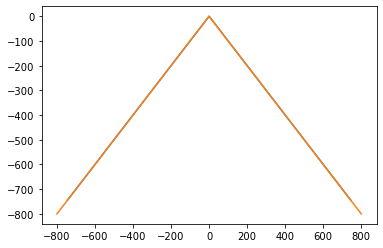

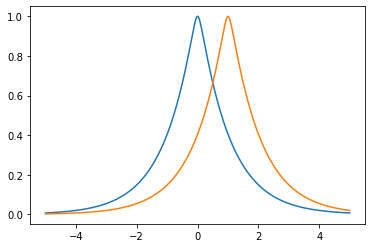

In [6]:
# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 1601
stretch = 1.0
lmax = 800

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

# CHARBONNIER FUNCTIONS, smoothed versions of the above unnormalized Laplace PDF
@jit
def xi(u):
    return np.exp(-(np.sqrt((u/zeta)**2 + 0.01) - 0.1))

# comparing, on a log scale, our chosen collocation function versus the unnormalized Laplace
plt.plot(uvec, np.log(xi(uvec)))
plt.plot(uvec, -np.abs(uvec/zeta))
plt.show()

# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))
plt.show()

In [7]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
JJ = 5
ximats = np.zeros((4*JJ+1, npts, npts))
for j in range(4*JJ+1):
    ximats[j, :, :] = xi(udiffmat + j - 2*JJ)
    
a = (1+0j)*ximats[2*JJ]
d = (1+0j)*np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

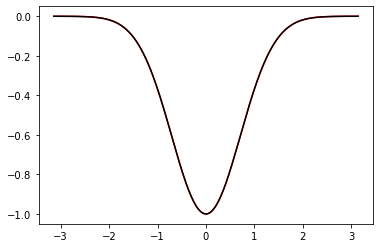

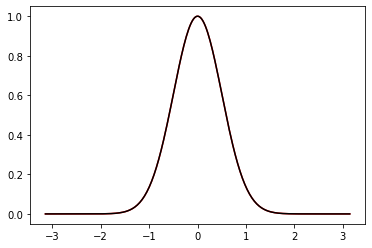

In [8]:
# set up true Fourier coefficients
truecoefs = np.zeros(2*JJ+1, dtype=np.complex128)
for j in range(-JJ, JJ+1):
    truecoefs[j+JJ] = (-1j/(4*np.sqrt(np.pi)))*np.exp(-j**2/4)*(ss.erfi(j/2 - 1j*np.pi) - ss.erfi(j/2 + 1j*np.pi))

# check whether these coefficients work for f(x)
xmax = np.pi
xpts = 256
xvec = np.linspace(-xmax, xmax, xpts)
testfn = np.zeros(xpts, dtype=np.complex128)
for j in range(-JJ, JJ+1):
    testfn += truecoefs[j+JJ]*np.exp(1j*j*xvec)

plt.plot(xvec, np.real(testfn), color='red')
plt.plot(xvec, -np.exp(-xvec**2), color='black')
plt.show()

# check whether these coefficients work for f^2(x)
# note convolution below
testfn = np.zeros(xpts, dtype=np.complex128)
for k in range(-2*JJ, 2*JJ+1):
    thiscoef = 0
    for j in range(-JJ, JJ+1):
        if np.abs(k-j) <= JJ:
            thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
    testfn += thiscoef*np.exp(1j*k*xvec)

plt.plot(xvec, np.real(testfn), color='red')
plt.plot(xvec, np.exp(-2*xvec**2), color='black')
plt.show()

In [9]:
# by hand version of scipy.signal.convolve
# convcoefs = np.zeros(4*JJ+1, dtype=np.complex128)
# for k in range(-2*JJ, 2*JJ+1):
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             convcoefs[k+2*JJ] += truecoefs[j+JJ]*truecoefs[k-j+JJ]

start = time.time()

b = 1j*h*np.einsum('i,ijk->jk',truecoefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
convcoefs = sig.convolve(truecoefs, truecoefs)
b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)

end = time.time()
print(end - start)

0.8836901187896729


In [10]:
# SLOW VERSION
# this b is actually b - a
# start = time.time()

# b = np.zeros((npts, npts), dtype=np.complex128)
# for j in range(-JJ, JJ+1):
#     b += 1j*truecoefs[j+JJ]*h*ximats[j+2*JJ,:,:] @ np.diag(uvec)
# for k in range(-2*JJ, 2*JJ+1):
#     thiscoef = 0
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
#     b += -0.5*h**2*thiscoef*ximats[k+2*JJ,:,:] @ np.diag(uvec**2)

# end = time.time()
# print(end - start)

# np.sum(np.abs(bnew - b))

In [11]:
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

# check stability of propagator
np.max(np.abs(np.linalg.eig(propagator)[0]))

# # no splitting -- warning, probably unstable
# # propagator = np.linalg.inv(a) @ d @ (a + b)

0.9999999999999997

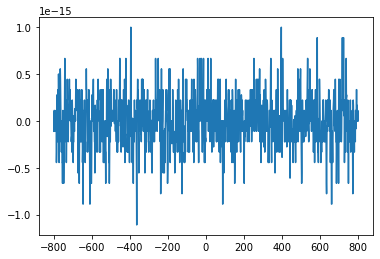

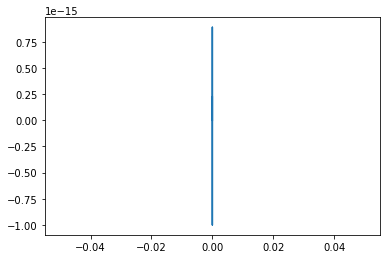

In [12]:
# set up initial condition, a mean-zero Gaussian (characteristic function)
initvar = 0.05
# psi0 = np.exp(-(initvar**2/2)*uvec**2)
# psi0 = np.ones(uvec.shape)
psi0 = np.exp(1j*0.5*uvec)

# represent initial condition using collocation functions
gamma = np.linalg.inv(a) @ psi0

# check to see how well we can reconstruct the initial condition 
plt.plot(np.real(uvec), np.real(a @ gamma - psi0))
plt.show()
plt.plot(np.imag(uvec), np.imag(a @ gamma - psi0))
plt.show()



In [13]:
# set up time stepping
# store all the characteristic functions
numsteps = 401
regsig = 0.005
gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
gammax1 = propagator @ gammax0

# gammamat = np.zeros((npts, numsteps))
# gammamat[:, 0] = gamma

# for iii in range(numsteps):
#     gammamat[:, iii+1] = propagator @ gammamat[:, iii]
#     normalization = a[(npts-1)//2, :] @ gammamat[:, iii+1]
#     print(normalization)
    
#     # forcefully renormalized at every time step
#     # we'd like to avoid doing this, as this is a total hack:
#     # gammamat[:, iii+1] /= normalization
#     # print( a[(npts-1)//2, :] @ gammamat[:, iii+1] )


(2000,)


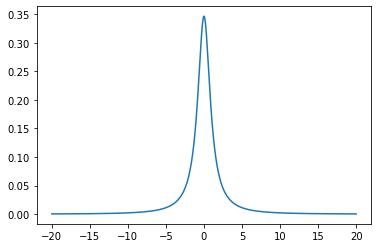

In [14]:
xmax = 20
xpts = 2000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

base = np.loadtxt('charboninv.csv')
print(base.shape)
plt.plot(xvec,base)

charboninv = interp.interp1d(xvec, base)
charbs = np.array(list(map(charboninv, mcsol[1:]))) 

In [15]:
# write a function
@jit
def myinterp(xvec, fval, xnew):
    inds = np.searchsorted(xvec, xnew)
    ar = np.arange(xnew.shape[0])
    dx = xvec[1] - xvec[0]
    fnew = (np.diag(fval[:,inds-1]) * (xvec[inds] - xnew) + np.diag(fval[:,inds]) * (xnew - xvec[inds-1]))/dx
    return fnew


# in this function, we take the first JJ+1 elements of theta to be the real parts of the coefs
# then the next JJ elements of theta to be the imag parts of coefs[1:]
def loglik(theta):
    # construct coefficients
    coefs = np.zeros(2*JJ+1, dtype=np.complex128)
    coefs[JJ:] += theta[:(JJ+1)]
    coefs[(JJ+1):] += 1j*theta[(JJ+1):]
    coefs[:JJ] = np.conj(np.flipud(coefs[(JJ+1):]))
    
    # non-jit'able version
    # utilize np.einsum and scipy.signal.convolve
    b = 1j*h*np.einsum('i,ijk->jk',coefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
    convcoefs = sig.convolve(coefs, coefs)
    b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)
    
    # jit'able version
    # b = np.zeros((npts, npts), dtype=np.complex128)
    # for j in range(-JJ, JJ+1):
    #     b += 1j*coefs[j+JJ]*h*ximats[j+2*JJ,:,:] @ np.diag((1+0j)*uvec)
    # for k in range(-2*JJ, 2*JJ+1):
    #     thiscoef = 0
    #     for j in range(-JJ, JJ+1):
    #         if np.abs(k-j) <= JJ:
    #             thiscoef += coefs[j+JJ]*coefs[k-j+JJ]
    #     b += -0.5*h**2*(1+0j)*thiscoef*ximats[k+2*JJ,:,:] @ np.diag((1+0j)*uvec**2)
    
    numsteps = 401
    regsig = 0.005
    gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
    gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
    gammax1 = np.linalg.solve(a - d @ b.T, d @ a @ gammax0) 
    allpdfs = myinterp(xvec, np.real(gammax1.T @ ftmat), mcsol[1:])
    
    loglik = np.log( allpdfs * charbs )
                    
    return np.sum(loglik)

In [16]:
loglik(truecoefs)

1252.53867999563

In [17]:
thetavec = np.linspace(0.5,1.5,100)

In [18]:
nreps = 101
nr2 = (nreps-1)//2
thetamat = np.tile(truecoefs,(nreps,1))
for j in range(nreps):
    thetamat[j,0] = truecoefs[0] + (j-nr2)/nr2


In [19]:
llvec = np.array(list(map(loglik, thetamat)))

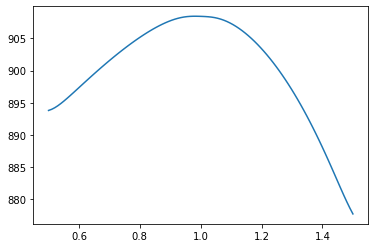

In [21]:
plt.plot(thetavec,llvec)

In [24]:
thetavec[np.argmax(llvec)]

0.9848484848484849

In [26]:
np.argsort([3.0,4.0,-1.0,0.0,3.0])[1]

3